In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import librosa
import scipy.io.wavfile as wav
import os

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
import torchaudio

In [4]:
root = "/kaggle/input/audio-mnist/data"
data = []
target = []
person = []

for i in range(1, 61):
    folderPath = os.path.join(root,str(i).zfill(2))
    files = os.listdir(folderPath)
    for file in files:
        tempPerson = ''
        temp = librosa.load(folderPath + '/' + file)
        temp = temp[0]
        target += file[0]
        person.append(int(i))
        data.append(temp)

In [6]:
pd.DataFrame(target).value_counts()

0    3000
1    3000
2    3000
3    3000
4    3000
5    3000
6    3000
7    3000
8    3000
9    3000
Name: count, dtype: int64

In [7]:
class_names=sorted(pd.DataFrame(target)[0].unique().tolist())

In [8]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

paddedDataa = pad_sequences(data, padding='post', dtype='float32')

In [9]:
paddedDataa.shape

(30000, 22050)

In [10]:
target = [int(item) for item in target]

In [84]:
import torch
from torch.utils.data import Dataset
import scipy.io.wavfile as wav
import librosa
from torch.nn.functional import pad
from tensorflow.keras.preprocessing.sequence import pad_sequences


class AudioMNISTDataset(Dataset):
    def __init__(self, X, y):
        self.ToSpectrogram = torchaudio.transforms.MelSpectrogram()
        self.ToDB = torchaudio.transforms.AmplitudeToDB()
        paddedDataa = pad_sequences(X, padding='post', dtype='float32')
        self.audio = paddedDataa
        self.labels = y
        assert(len(self.audio) == len(self.labels))
    
    def __len__(self):
        return len(self.audio)
    
    def padding(self, file):
        audio_padded = torch.zeros((1,25500))
        audio_padded[0,:len(file)] = torch.Tensor(file)
        return audio_padded
    
    def mfcc_data(self, file):
#         print(file)

        spectrogram = self.ToSpectrogram(file)
        spectrogram = self.ToDB(spectrogram)
        return spectrogram[0]
    
    def __getitem__(self, idx):
        padded = self.padding(self.audio[idx])
#         print(padded.size())
#         print(self.audio[idx])
#         audio_seq = self.mfcc_data(torch.tensor(self.audio[idx]))
        audio_seq = self.mfcc_data(padded)
#         print(audio_seq.size())
#         print(audio_seq)
        normalized_data = (audio_seq - (-100)) / (20 - (-100))
#         print(normalized_data.shape)
        normalized_data = torch.FloatTensor(normalized_data)

        label = self.labels[idx]
#         plt.imshow(normalized_data)
#         print(normalized_data.shape)
#         normalized_data = normalized_data.reshape(16384,)
#         print(normalized_data.shape)

#         normalized_data = normalized_data.permute(1, 2, 0)
        return normalized_data.flatten(), label

In [85]:
from sklearn.model_selection import train_test_split

In [86]:
X_train, X_test, y_train, y_test = train_test_split(paddedDataa, target, test_size=0.15, random_state=42)

In [87]:
from torch.utils.data import TensorDataset, DataLoader

train_loader = DataLoader(AudioMNISTDataset(X_train, y_train), batch_size=32, shuffle=True)
test_loader = DataLoader(AudioMNISTDataset(X_test, y_test), batch_size=32)

/opt/conda/lib/python3.10/site-packages/torchaudio/functional/functional.py:576: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


In [88]:
# for images, labels in train_loader:
#     print(type(images))    
#     print(images.shape)
#     print(images.max())
#     break
x, y = next(iter(train_loader))
x.shape, y.shape

(torch.Size([32, 16384]), torch.Size([32]))

In [89]:
print(y)

tensor([6, 2, 8, 9, 4, 5, 3, 2, 5, 4, 5, 5, 8, 7, 6, 9, 9, 7, 0, 3, 6, 8, 4, 7,
        8, 7, 1, 4, 9, 2, 5, 0])


In [90]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from sklearn.metrics import accuracy_score

In [91]:
import torch
import torch.nn as nn
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
import matplotlib.pyplot as plt

class VoiceMNISTTransformer(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes, num_heads, num_layers):
        super(VoiceMNISTTransformer, self).__init__()

        self.embedding = nn.Linear(input_dim, hidden_dim)
#         self.transformer = nn.TransformerEncoder(
#             nn.TransformerEncoderLayer(d_model=hidden_dim, nhead=num_heads),
#             num_layers=num_layers
#         )
        self.transformer = nn.Transformer(d_model=hidden_dim,
                                          num_encoder_layers=num_layers,
                                          num_decoder_layers=num_layers,
                                          nhead=num_heads,
                                          batch_first=True).encoder
        self.fc = nn.Linear(hidden_dim, num_classes)
        self.bn = nn.LazyBatchNorm1d()

    def forward(self, x):
#         print(x.shape)
        x = self.bn(self.embedding(x)).relu()
#         x = x.view(x.size(0), x.size(1), -1)  # Reshape to [sequence_length, batch_size, feature_dim]
#         x = x.permute(1, 0, 2)
#         print(x.shape)
        output = self.transformer(x)
#         output = output.mean(dim=0)# Aggregate across time steps
#         print(output.shape)
        output = self.fc(output)

        return output


In [81]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [82]:
device

'cuda'

In [139]:
model = VoiceMNISTTransformer(16384, 1024, 10, 8, 6).to(device)

In [140]:
model(x.to(device)).shape

torch.Size([32, 10])

In [93]:
# Assuming your spectrogram images have a shape (batch_size, num_channels, height, width)
input_dim = 16384  # Adjust based on the actual width of your spectrogram
hidden_dim = 512
num_classes = 10  # Number of classes (digits 0 to 9)
num_heads = 8
num_layers = 4
num_epochs = 10
model = VoiceMNISTTransformer(input_dim, hidden_dim, num_classes, num_heads, num_layers).to(device)
start_time = time.time()
train_losses = []
test_losses = []
train_accuracy = []
test_accuracy = []
num = []
# Define your loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
counter = 0
# Now you can use the trained model for prediction
for epoch in range(num_epochs):
    print(f"\nEpoch {epoch + 1}/{num_epochs}")
    model.train()
    
    trn_corr = 0
    for batch_idx, (X_train, y_train) in enumerate(train_loader):
        optimizer.zero_grad()
        y_pred = model(X_train.to(device))
        loss = criterion(y_pred, y_train.to(device))
        loss.backward()
        optimizer.step()
        counter += 1
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train.to(device)).sum()
        trn_corr += batch_corr

#         if batch_idx % 100 == 0:
#         if batch_idx % 100 == 1:
        if batch_idx != 0:
#             print(f"Training Batch {batch_idx}/{len(train_loader)} Loss: {loss.item():.6f}")
            train_accuracy.append(trn_corr.item() * 100 / ((32 * batch_idx)+1))
            num.append(counter/len(train_loader))
            train_losses.append(loss.item())

#     train_loss = loss.item()
#     train_acc = trn_corr.item() * 100 / (32 * (batch_idx + 1))
#     train_losses.append(train_loss)
#     train_accuracy.append(train_acc)

#     Validation/Test phase
            if batch_idx % 100 == 1:

                model.eval()
                tst_corr = 0
                all_true = []
                all_pred = []

                with torch.no_grad():
                    for batch_idx, (X_test, y_test) in enumerate(test_loader):
                        X_test = X_test.to(device)
                        y_test = y_test.to(device)
                        y_val = model(X_test)
                        loss = criterion(y_val, y_test)

                        predicted = torch.max(y_val.data, 1)[1]
                        batch_corr = (predicted == y_test).sum()
                        tst_corr += batch_corr

                        all_true.extend(y_test.cpu().numpy())
                        all_pred.extend(predicted.cpu().numpy())

                test_loss = loss.item()
                test_acc = tst_corr.item() * 100 / len(test_loader.dataset)
                test_losses.append(test_loss)
                test_accuracy.append(test_acc)

                # Compute and print F1 score, accuracy, precision, and recall
                f1 = f1_score(all_true, all_pred, average='weighted')
                acc = accuracy_score(all_true, all_pred)
                precision = precision_score(all_true, all_pred, average='weighted')
                recall = recall_score(all_true, all_pred, average='weighted')

                print(f"\nValidation/Test Loss: {test_loss:.6f}, Accuracy: {test_acc:.2f}%")
                print(f"F1 Score: {f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}")



/opt/conda/lib/python3.10/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '



Epoch 1/10


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Validation/Test Loss: 2.367240, Accuracy: 15.11%
F1 Score: 0.0867, Precision: 0.1088, Recall: 0.1511


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Validation/Test Loss: 1.871769, Accuracy: 31.36%
F1 Score: 0.2265, Precision: 0.3350, Recall: 0.3136

Validation/Test Loss: 0.633748, Accuracy: 78.89%
F1 Score: 0.7791, Precision: 0.8325, Recall: 0.7889

Validation/Test Loss: 0.211220, Accuracy: 89.62%
F1 Score: 0.8926, Precision: 0.9048, Recall: 0.8962

Validation/Test Loss: 0.118471, Accuracy: 93.98%
F1 Score: 0.9398, Precision: 0.9415, Recall: 0.9398

Validation/Test Loss: 0.092610, Accuracy: 93.62%
F1 Score: 0.9360, Precision: 0.9416, Recall: 0.9362

Validation/Test Loss: 0.064987, Accuracy: 94.96%
F1 Score: 0.9496, Precision: 0.9518, Recall: 0.9496

Validation/Test Loss: 0.177325, Accuracy: 92.38%
F1 Score: 0.9256, Precision: 0.9354, Recall: 0.9238

Epoch 2/10

Validation/Test Loss: 0.108227, Accuracy: 90.42%
F1 Score: 0.9037, Precision: 0.9176, Recall: 0.9042

Validation/Test Loss: 0.036675, Accuracy: 95.47%
F1 Score: 0.9548, Precision: 0.9567, Recall: 0.9547

Validation/Test Loss: 0.018500, Accuracy: 96.69%
F1 Score: 0.9668, Pr

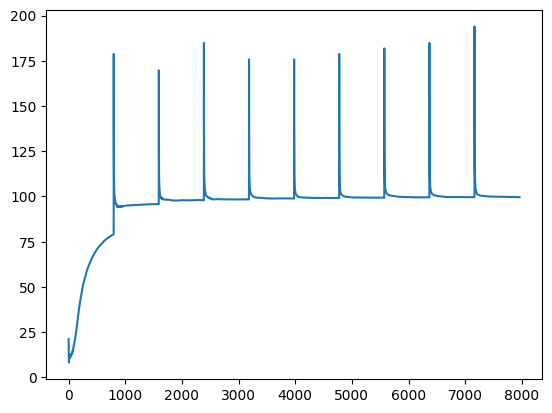

In [94]:
plt.plot(train_accuracy)

In [ ]:
# Plotting
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Test Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(test_accuracy, label='Test Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

print(f'\nTotal Duration: {time.time() - start_time:.0f} seconds')

In [36]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader, random_split
from torch.utils.data import Dataset
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn.functional as F

# Assuming you have a dataset class (CustomDataset) for your images

# Define the transformer model for image classification
class TransformerClassifier(nn.Module):
    def __init__(self, input_size, num_classes, d_model=128, nhead=8, num_layers=6):
        super(TransformerClassifier, self).__init__()
        self.bn = nn.LazyBatchNorm1d()

        self.embedding = nn.Linear(input_size, d_model)
        self.transformer = nn.Transformer(
            d_model=d_model,
            nhead=nhead,
            num_encoder_layers=num_layers,
            num_decoder_layers=num_layers,
        )
        self.fc = nn.Linear(d_model, num_classes)

    def forward(self, x):
        x = self.bn(self.embedding(x)).relu()
        x = x.permute(1, 0, 2)  # Change the shape for the transformer input

        # Create a fixed positional encoding as a target sequence
        src = tgt = x

        output = self.transformer(src, tgt)
        output = output.mean(dim=0)  # Aggregate across sequence length
        output = self.fc(output)
        return output

# Hyperparameters
input_size = 128 * 128  # Assuming grayscale images
num_classes = 10
batch_size = 32
learning_rate = 0.001
num_epochs = 10

# Data loading and preprocessing
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert image to PyTorch tensor
    # Add other transformations as needed (e.g., normalization, data augmentation)
])


model = TransformerClassifier(input_size=input_size, num_classes=num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
for epoch in range(num_epochs):
    model.train()
    for (batch, labels) in train_loader:
        inputs = batch  # Assuming the data loader returns batches of images
#         labels = torch.randint(0, num_classes, (batch_size,))
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train.to(device)).sum()
        trn_corr += batch_corr

#         if batch_idx % 100 == 0:
#         if batch_idx % 100 == 1:
        print(f"Training Batch {batch_idx}/{len(train_loader)} Loss: {loss.item():.6f}")
        train_accuracy.append(trn_corr.item() * 100 / ((32 * batch_idx) + 1))
        train_losses.append(loss.item())
            
    # Evaluation on the test set
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for batch in test_loader:
            inputs = batch  # Assuming the data loader returns batches of images
            labels = torch.randint(0, num_classes, (batch_size,))
            
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    print(f'Epoch {epoch+1}/{num_epochs}, Test Accuracy: {accuracy}')

# Save the trained model if needed
torch.save(model.state_dict(), 'transformer_classifier.pth')


RuntimeError: mat1 and mat2 shapes cannot be multiplied (32x49152 and 16384x256)

In [40]:
device = 'cpu'

In [51]:
embed_size = 256
num_heads = 4
hidden_dim = 512
num_classes = 10
train_accuracy = []
train_losses = []
model = ImageTransformer(embed_size, num_heads, hidden_dim, num_classes)
for epoch in range(num_epochs):
    print(f"\nEpoch {epoch + 1}/{num_epochs}")
    model.train()
    trn_corr = 0
    for batch_idx, (X_train, y_train) in enumerate(train_loader):
        optimizer.zero_grad()
        y_pred = model(X_train.to(device))
        loss = criterion(y_pred, y_train.to(device))
        loss.backward()
        optimizer.step()

        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train.to(device)).sum()
        trn_corr += batch_corr

#         if batch_idx % 100 == 0:
#         if batch_idx % 100 == 1:
        print(f"Training Batch {batch_idx}/{len(train_loader)} Loss: {loss.item():.6f}")
        train_accuracy.append(trn_corr.item() * 100 / ((32 * batch_idx)+1))
        train_losses.append(loss.item())

#     train_loss = loss.item()
#     train_acc = trn_corr.item() * 100 / (32 * (batch_idx + 1))
#     train_losses.append(train_loss)
#     train_accuracy.append(train_acc)

    # Validation/Test phase
#             model.eval()
#             tst_corr = 0
#             all_true = []
#             all_pred = []

#             with torch.no_grad():
#                 for batch_idx, (X_test, y_test) in enumerate(test_loader):
#                     X_test = X_test.to(device)
#                     y_test = y_test.to(device)
#                     y_val = model(X_test)
#                     loss = criterion(y_val, y_test)

#                     predicted = torch.max(y_val.data, 1)[1]
#                     batch_corr = (predicted == y_test).sum()
#                     tst_corr += batch_corr

#                     all_true.extend(y_test.cpu().numpy())
#                     all_pred.extend(predicted.cpu().numpy())

#             test_loss = loss.item()
#             test_acc = tst_corr.item() * 100 / len(test_loader.dataset)
#             test_losses.append(test_loss)
#             test_accuracy.append(test_acc)

#             # Compute and print F1 score, accuracy, precision, and recall
#             f1 = f1_score(all_true, all_pred, average='weighted')
#             acc = accuracy_score(all_true, all_pred)
#             precision = precision_score(all_true, all_pred, average='weighted')
#             recall = recall_score(all_true, all_pred, average='weighted')

#             print(f"\nValidation/Test Loss: {test_loss:.6f}, Accuracy: {test_acc:.2f}%")
#             print(f"F1 Score: {f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}")




Epoch 1/10
Training Batch 0/797 Loss: 2.411335
Training Batch 1/797 Loss: 2.491004
Training Batch 2/797 Loss: 2.422049
Training Batch 3/797 Loss: 2.328957
Training Batch 4/797 Loss: 2.209886
Training Batch 5/797 Loss: 2.402220
Training Batch 6/797 Loss: 2.341486
Training Batch 7/797 Loss: 2.524942
Training Batch 8/797 Loss: 2.496173
Training Batch 9/797 Loss: 2.238711
Training Batch 10/797 Loss: 2.387328
Training Batch 11/797 Loss: 2.383668
Training Batch 12/797 Loss: 2.457969
Training Batch 13/797 Loss: 2.246213
Training Batch 14/797 Loss: 2.362269
Training Batch 15/797 Loss: 2.597957
Training Batch 16/797 Loss: 2.418842
Training Batch 17/797 Loss: 2.557679
Training Batch 18/797 Loss: 2.325555
Training Batch 19/797 Loss: 2.416922
Training Batch 20/797 Loss: 2.579286
Training Batch 21/797 Loss: 2.370956
Training Batch 22/797 Loss: 2.430666
Training Batch 23/797 Loss: 2.469038
Training Batch 24/797 Loss: 2.404148
Training Batch 25/797 Loss: 2.532107
Training Batch 26/797 Loss: 2.262216

KeyboardInterrupt: 